In [3]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import csv
import pandas as pd
from hdbscan import HDBSCAN
from transformers import AutoModel
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import nltk
import random
random.seed("ic2s2colgne")
import numpy as np

In [4]:
random.seed(2022)
np.random.seed(2022)

### Datasets combination

In [5]:
media = pd.read_csv("media_clean.csv", header = 0, delimiter = ",")
media.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)

In [6]:
len(media)

38138

In [7]:
corporation = pd.read_csv("corporation_clean.csv", header = 0, delimiter = ",")
corporation.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)

In [8]:
len(corporation)

161135

In [10]:
media["source_media"] = 1
corporation["source_media"] = 0

In [11]:
all_tweets = pd.concat([media, corporation], ignore_index=True)

In [12]:
len(all_tweets)

199273

In [13]:
all_tweets.head()

,created_at,text,id,author_id,lang,username,text_clean,source_media
0,2021-12-31 12:06:05,'That was not the basis of the CDC's decision'...,1476887381336801280,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1
1,2021-12-30 02:46:02,'That was not the basis of the CDC's decision'...,1476384051154112512,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1
2,2021-12-29 13:31:07,'That was not the basis of the CDC's decision'...,1476184003526938624,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1
3,2021-12-29 06:31:02,'That was not the basis of the CDC's decision'...,1476078288661581824,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1
4,2021-08-25 19:34:01,Delta Air Lines CEO tells employees that they ...,1430614459077349376,2836421,en,MSNBC,delta air lines ceo tells employees that they ...,1


### Sampling

In [14]:
df = all_tweets.sample(40000, ignore_index = True)

In [15]:
text = df["text_clean"].to_list()

### Reduce outliers

**Reason for too many outliers**

"The reduced embeddings are clustering used HDBSCAN (McInnes et al., 2017). It is an extension of DBSCAN that finds clusters of varying
densities by converting DBSCAN into a hierarchical clustering algorithm. HDBSCAN models clusters using a soft-clustering approach allowing noise to be modeled as outliers. This prevents unrelated documents to be assigned to any cluster and is expected to improve topic representations.‘Moreover, (Allaoui et al., 2020) demonstrated that reducing high dimensional embeddings with UMAP can improve the performance of well-known clustering algorithms, such as k-Means and HDBSCAN, both in terms of clustering accuracy and time."

*from: Grootendorst, M. (2022). BERTopic: Neural topic modeling with a class-based TF-IDF procedure. arXiv preprint arXiv:2203.05794.*

https://github.com/MaartenGr/BERTopic/issues/334


Importantly HDBSCAN is noise aware – it has a notion of data samples that are not assigned to any cluster. This is handled by assigning these samples the label -1

The amount of data classified as noise is controlled by the min_samples parameter. By default, if not otherwise set, this value is set to the same value as min_cluster_size. You can set it independently if you wish by specifying it separately. The lower the value, the less noise you’ll get
https://hdbscan.readthedocs.io/en/latest/faq.html#q-most-of-data-is-classified-as-noise-why


For hdbscan: 
- min_samples = the minimum number of neighbours to a core point.  The higher this is, the more points are going to be discarded as noise/outliers.
- min_cluster_size = the minimum size a final cluster can be.

#### Original results

In [16]:
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=5, max_df=.5)

In [17]:
topic_modela = BERTopic(vectorizer_model=vectorizer_model, calculate_probabilities=False, low_memory=True, verbose=True, 
                       nr_topics="auto", diversity = 0.2, min_topic_size = 30)

In [18]:
topics, probs = topic_modela.fit_transform(text)

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

2022-06-08 17:59:24,826 - BERTopic - Transformed documents to Embeddings
2022-06-08 17:59:53,873 - BERTopic - Reduced dimensionality
2022-06-08 17:59:58,101 - BERTopic - Clustered reduced embeddings
2022-06-08 18:00:24,114 - BERTopic - Reduced number of topics from 184 to 30


In [19]:
topic_modela.get_topic_info()

,Topic,Count,Name
0,0,19627,0_covid19_vaccine_data_card
1,-1,17399,-1_covid19_health_tech_amazon
2,1,328,1_happy_holiday_christmas_holiday season
3,2,321,2_students_teachers_education_schools
4,3,313,3_women_gender_womens_leadership
5,4,278,4_airlines_flight_southwest_max
6,5,220,5_diversity_diversity inclusion_workplace_equi...
7,6,173,6_retirement_income_tiaa_savings
8,7,131,7_giving_donate_grants_donating
9,8,100,8_kkr_real estate_estate_equity


In [20]:
topic_modela.get_topic(-1)
# all_tweets["text_clean"][all_tweets['topic'] == -1].to_list()[:10]

[('covid19', 0.009876706346381565),
 ('health', 0.00819433643380386),
 ('tech', 0.008175962714220534),
 ('amazon', 0.007418425884371932),
 ('financial', 0.007244041964170928),
 ('communities', 0.007011570898784041),
 ('game', 0.0069204995394863515),
 ('sta', 0.006908631436662869),
 ('service', 0.006454063777933257),
 ('episode', 0.006409802180186001)]

In [21]:
# Calculate cohenrence
text_bigrams = [[" ".join(tup) for tup in nltk.ngrams(n.split(),2)] for n in text]

In [22]:
assert len(text)==len(text_bigrams)
text_uniandbigrams = []
for a,b in zip([n.split() for n in text],text_bigrams):
    text_uniandbigrams.append(a + b)

In [23]:
id2word = corpora.Dictionary(text_uniandbigrams)
corpus = [id2word.doc2bow(text) for text in text_uniandbigrams]

In [24]:
topics=[]
for i in topic_modela.get_topics():
    row=[]
    topic= topic_modela.get_topic(i)
    for word in topic:
        row.append(word[0])
        topics.append(row)

In [25]:
cma = CoherenceModel(topics=topics, texts=text_uniandbigrams, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence = cma.get_coherence() 
print('\nCoherence Score: ', coherence)


Coherence Score:  -10.136064900148764


#### Option1: fine tune the hdbscan model
- can reduce the outliers, but generate more topics (min_topic_size stops working)
- Force texts go to topics will lower the coherence

In [26]:
hdbscan_model = HDBSCAN(min_samples=5)

In [27]:
topic_modelb = BERTopic(vectorizer_model=vectorizer_model, hdbscan_model=hdbscan_model, calculate_probabilities=False, low_memory=True, verbose=True, 
                       nr_topics="auto", diversity = 0.2, min_topic_size = 30)

In [28]:
topics, probs = topic_modelb.fit_transform(text)

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

2022-06-08 18:16:19,959 - BERTopic - Transformed documents to Embeddings
2022-06-08 18:16:38,504 - BERTopic - Reduced dimensionality
2022-06-08 18:16:42,491 - BERTopic - Clustered reduced embeddings
2022-06-08 18:20:33,115 - BERTopic - Reduced number of topics from 1269 to 822


In [29]:
topic_modelb.get_topic_info()

,Topic,Count,Name
0,-1,15161,-1_amp_pandemic_work_join
1,0,741,0_vaccine_covid19 vaccine_vaccines_covid19
2,1,661,1_cash_fee_banking_visa
3,2,394,2_boeing_airlines_american airlines_aircraft
4,3,355,3_netflix_vegas_las vegas_new netflix
...,...,...,...
796,816,5,816_employees committed_hardworking_day today_...
797,817,5,817_plans expand_impact repo_foundations_susta...
798,818,5,818_togetherness_digital capabilities_minneapo...
799,819,5,819_spencer_mental wellbeing_pulse_steps taking


In [30]:
# Investigate the outliers
topic_modelb.get_topic(-1)

[('amp', 0.001280847923530813),
 ('pandemic', 0.0011384250234501736),
 ('work', 0.0011383323648571913),
 ('join', 0.0011080656436283454),
 ('day', 0.001090624688410012),
 ('cloud', 0.0010793524028327793),
 ('ceo', 0.0010634773733559557),
 ('suppo', 0.001022915152561685),
 ('industry', 0.001017115484560298),
 ('tech', 0.0010029119883239233)]

In [31]:
topics=[]
for i in topic_modelb.get_topics():
    row=[]
    topic= topic_modelb.get_topic(i)
    for word in topic:
        row.append(word[0])
        topics.append(row)

In [32]:
cmb = CoherenceModel(topics=topics, texts=text_uniandbigrams, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence = cmb.get_coherence() 
print('\nCoherence Score: ', coherence)


Coherence Score:  -12.15737822900106


#### Option2: fine tune the transformer model

In [33]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
topic_modelc = BERTopic(vectorizer_model=vectorizer_model, embedding_model=bertweet, calculate_probabilities=False, low_memory=True, verbose=True, 
                       nr_topics="auto", diversity = 0.2, min_topic_size = 30)

In [35]:
topics, probs = topic_modelc.fit_transform(text)

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

2022-06-08 18:36:34,842 - BERTopic - Transformed documents to Embeddings
2022-06-08 18:36:53,515 - BERTopic - Reduced dimensionality
2022-06-08 18:36:57,612 - BERTopic - Clustered reduced embeddings
2022-06-08 18:37:35,131 - BERTopic - Reduced number of topics from 183 to 126


In [36]:
topic_modelc.get_topic_info()

,Topic,Count,Name
0,-1,17892,-1_covid19_pandemic_data_ceo
1,0,1765,0_vaccine_covid19_covid_vaccines
2,1,1571,1_apple_cloud_security_cybersecurity
3,2,1071,2_sustainability_emissions_carbon_climate change
4,3,1028,3_netflix_disney_streaming_movies
...,...,...,...
121,120,32,120_valentine_valentines day_valentines_friends
122,121,32,121_trailblazers_trailblazer_df21_salesforce
123,122,31,122_juneteenth_slavery_historic_statue
124,123,31,123_gifts_gift_gifting_holiday season


In [37]:
topic_modelc.get_topic(-1)

[('covid19', 0.0046239186738339),
 ('pandemic', 0.0041639110059784705),
 ('data', 0.0037046881760774),
 ('ceo', 0.0035692291292427625),
 ('program', 0.003490336435868489),
 ('health', 0.0033655546311951077),
 ('tech', 0.003300576553909974),
 ('financial', 0.003247008254228667),
 ('employees', 0.003168455234804353),
 ('businesses', 0.00301553538031827)]

In [38]:
topics=[]
for i in topic_modelc.get_topics():
    row=[]
    topic= topic_modelc.get_topic(i)
    for word in topic:
        row.append(word[0])
        topics.append(row)

In [39]:
cmc = CoherenceModel(topics=topics, texts=text_uniandbigrams, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence = cmc.get_coherence() 
print('\nCoherence Score: ', coherence)


Coherence Score:  -10.299237950315236


In [40]:
# another transformer model
from transformers import BertModel

In [41]:
model = BertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
topic_modeld = BERTopic(vectorizer_model=vectorizer_model, embedding_model=model, calculate_probabilities=False, low_memory=True, verbose=True, 
                       nr_topics="auto", diversity = 0.2, min_topic_size = 30)

In [43]:
topics, probs = topic_modeld.fit_transform(text)

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

2022-06-08 18:59:19,995 - BERTopic - Transformed documents to Embeddings
2022-06-08 18:59:38,831 - BERTopic - Reduced dimensionality
2022-06-08 18:59:42,954 - BERTopic - Clustered reduced embeddings
2022-06-08 19:00:23,803 - BERTopic - Reduced number of topics from 189 to 134


In [44]:
topic_modeld.get_topic_info()

,Topic,Count,Name
0,-1,16592,-1_covid19_pandemic_data_cash
1,0,1467,0_netflix_disney_shows_unlimited
2,1,1200,1_cloud_facebook_netapp_privacy
3,2,1168,2_vaccine_covid19_pfizer_fda
4,3,1119,3_sustainability_emissions_carbon_climate change
...,...,...,...
129,128,32,128_cognizant_cognizantnews_leadership_becogni...
130,129,31,129_zones_digital divide_spaces_end year
131,130,31,130_oral_colgate_dental_mouth
132,131,31,131_sta saving_pay_safer_18 months


In [45]:
topic_modeld.get_topic(-1)

[('covid19', 0.004384889400178895),
 ('pandemic', 0.003977198644704518),
 ('data', 0.0036418217928967126),
 ('cash', 0.0035203871516700414),
 ('tech', 0.0033444488165364976),
 ('innovation', 0.0033156774572741994),
 ('companies', 0.0032424087575896885),
 ('employees', 0.0032027078224905223),
 ('businesses', 0.0029668561701399797),
 ('microsoft', 0.002891244812657453)]

In [46]:
topics=[]
for i in topic_modeld.get_topics():
    row=[]
    topic= topic_modeld.get_topic(i)
    for word in topic:
        row.append(word[0])
        topics.append(row)

In [47]:
cmd = CoherenceModel(topics=topics, texts=text_uniandbigrams, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence = cmd.get_coherence() 
print('\nCoherence Score: ', coherence)


Coherence Score:  -10.713354660056531


In [48]:
# another transformer model
from transformers import GPT2Model

In [49]:
model = GPT2Model.from_pretrained('distilgpt2')

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
topic_modele = BERTopic(vectorizer_model=vectorizer_model, embedding_model=model, calculate_probabilities=False, low_memory=True, verbose=True, 
                       nr_topics="auto", diversity = 0.2, min_topic_size = 30)

In [51]:
topics, probs = topic_modele.fit_transform(text)

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

2022-06-08 19:24:34,092 - BERTopic - Transformed documents to Embeddings
2022-06-08 19:24:52,758 - BERTopic - Reduced dimensionality
2022-06-08 19:24:56,710 - BERTopic - Clustered reduced embeddings
2022-06-08 19:25:36,029 - BERTopic - Reduced number of topics from 188 to 124


In [52]:
topic_modele.get_topic_info()

,Topic,Count,Name
0,-1,16938,-1_digital_health_pandemic_covid19
1,0,2005,0_netflix_disney_streaming_nfl
2,1,1940,1_points_cash_earn_purchases
3,2,1336,2_vaccine_covid19_vaccines_covid
4,3,1146,3_sustainability_emissions_carbon_climate change
...,...,...,...
119,118,32,118_relief_storms_disaster_impacted
120,119,32,119_comcast_bold_designer_monica
121,120,32,120_wildlife_protecting_animals_backyard
122,121,31,121_iot_edge_internet_ecosystem


In [53]:
topic_modele.get_topic(-1)

[('digital', 0.0042004737679891095),
 ('health', 0.00418569186462933),
 ('pandemic', 0.004147426909685661),
 ('covid19', 0.004002570021606288),
 ('data', 0.0038391853854446213),
 ('ceo', 0.0038295914943291937),
 ('amazon', 0.0033477511004835485),
 ('companies', 0.0032728694024012077),
 ('tech', 0.003207347043225077),
 ('security', 0.002976029133802952)]

In [54]:
topics=[]
for i in topic_modele.get_topics():
    row=[]
    topic= topic_modele.get_topic(i)
    for word in topic:
        row.append(word[0])
        topics.append(row)

In [55]:
cme = CoherenceModel(topics=topics, texts=text_uniandbigrams, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence = cme.get_coherence() 
print('\nCoherence Score: ', coherence)


Coherence Score:  -10.141653816637218


**Go with the "bert-base-uncased" model**

# LDA

In [32]:
import csv
from nltk.sentiment import vader
import nltk
import gensim
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pandas as pd
import random
random.seed("ic2s2colgne")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
random.seed(2345)
np.random.seed(2345)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
media_text = media["text_clean"].to_list()

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
from nltk.corpus import stopwords
mystopwords = stopwords.words("english")
text = [" ".join([w for w in n.split() if w not in mystopwords]) for n in media_text]

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Word frequency or tf-idf score

In [63]:
ldainput_m1 = [n.split() for n in text]
id2word_m1 = corpora.Dictionary(ldainput_m1)
ldacorpus_m1 = [id2word_m1.doc2bow(doc) for doc in ldainput_m1]
lda_m1 = models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=10, random_state=40)
lda_m1.print_topics(num_words=5)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.039*"200" + 0.030*"unvaccinated" + 0.018*"shooting" + 0.013*"say" + 0.012*"man"'),
 (1,
  '0.044*"pfizer" + 0.036*"vaccine" + 0.028*"covid19" + 0.015*"vaccines" + 0.013*"booster"'),
 (2,
  '0.045*"lines" + 0.043*"air" + 0.042*"delta" + 0.028*"apple" + 0.025*"flight"'),
 (3,
  '0.035*"buy" + 0.035*"best" + 0.020*"pill" + 0.017*"google" + 0.011*"amazon"'),
 (4,
  '0.020*"dose" + 0.017*"health" + 0.015*"us" + 0.014*"insurance" + 0.014*"covid19"'),
 (5,
  '0.052*"johnson" + 0.019*"amp" + 0.016*"new" + 0.012*"series" + 0.012*"2021"'),
 (6,
  '0.030*"monthly" + 0.014*"approved" + 0.013*"kids" + 0.012*"review" + 0.012*"seats"'),
 (7,
  '0.035*"vaccine" + 0.030*"delta" + 0.030*"covid19" + 0.028*"air" + 0.022*"lines"'),
 (8,
  '0.020*"passenger" + 0.017*"app" + 0.016*"know" + 0.014*"pilots" + 0.012*"via"'),
 (9,
  '0.041*"disney" + 0.009*"target" + 0.009*"new" + 0.009*"netflix" + 0.009*"us"')]

In [64]:
ldacorpus_m2 = ldacorpus_m1
id2word_m2 = id2word_m1
tfidfcorpus_m2 = models.TfidfModel(ldacorpus_m2)
lda_m2 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2,num_topics=10,random_state=40)
lda_m2.print_topics(num_words=5)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"places" + 0.010*"shooting" + 0.008*"recommended" + 0.008*"facility" + 0.008*"cleaning"'),
 (1,
  '0.014*"vaccine" + 0.012*"covid19" + 0.011*"delta" + 0.010*"air" + 0.010*"booster"'),
 (2,
  '0.031*"delta" + 0.026*"lines" + 0.018*"air" + 0.013*"flight" + 0.009*"pfizer"'),
 (3,
  '0.035*"unvaccinated" + 0.026*"monthly" + 0.018*"insurance" + 0.011*"fda" + 0.009*"mr"'),
 (4,
  '0.031*"johnson" + 0.020*"surcharge" + 0.008*"amp" + 0.006*"polish" + 0.006*"regulators"'),
 (5,
  '0.019*"series" + 0.011*"doesnt" + 0.010*"markgurman" + 0.008*"blood" + 0.007*"subject"'),
 (6,
  '0.011*"complicated" + 0.011*"seats" + 0.011*"defense" + 0.011*"approved" + 0.010*"young"'),
 (7,
  '0.017*"spokesperson" + 0.011*"netflix" + 0.007*"holiday" + 0.007*"additional" + 0.006*"severe"'),
 (8,
  '0.015*"passenger" + 0.012*"pilots" + 0.010*"unruly" + 0.008*"8" + 0.008*"protection"'),
 (9,
  '0.016*"lines" + 0.012*"pfizer" + 0.012*"buy" + 0.011*"disney" + 0.011*"best"')]

#### Number of topics
I looped through several possible topic numbers and plotted the coherence and perplexity value to find out the inflection point.

In [65]:
ldacorpus_perplex = ldacorpus_m2.copy()
random.shuffle(ldacorpus_perplex)

splitidx = int(0.8 * len(ldacorpus_perplex))

train = ldacorpus_perplex[:splitidx]
test = ldacorpus_perplex[splitidx:]

tfidfcorpus_train = models.TfidfModel(train)
tfidfcorpus_test = models.TfidfModel(test)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


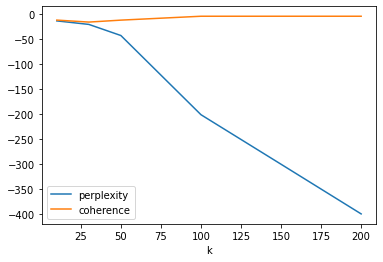

In [66]:
result = []

for k in [10, 30, 50, 100, 150, 200]:
    lda = models.ldamodel.LdaModel(corpus=tfidfcorpus_train[train], id2word=id2word_m1, num_topics=k, random_state=40)
    perplexity = lda.log_perplexity(tfidfcorpus_test[test])
    coherence = models.CoherenceModel(model=lda, corpus=tfidfcorpus_test[test], coherence= "u_mass").get_coherence()
    result.append(dict(k=k, perplexity=perplexity, coherence=coherence))

result = pd.DataFrame(result)
result.plot(x="k", y=["perplexity", "coherence"])
plt.show()

no large difference to coherence, explore 45-55 topics for perplexity

In [67]:
perplexityvalues = []
for n in np.arange(45,56):
    lda = models.LdaModel(corpus=tfidfcorpus_train[train], id2word=id2word_m1, num_topics=n, random_state=40)
    print(lda.log_perplexity(test), lda.bound(test))
    perplexityvalues.append((n, lda.log_perplexity(test)))

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-23.410690340000365 -2761262.6466261325
-25.063813330113167 -2956173.9878457505
-26.570008638422255 -3133895.1324252994
-28.714044140447374 -3386803.8694926896
-31.628509813820585 -3730491.9220177922
-34.25878431931146 -4040749.974515808
-38.99467301065707 -4599305.239704966
-42.90579584266947 -5060660.86182851
-47.14941054039575 -5561164.71446617
-52.78704171643259 -6226124.877868057
-56.38529571909093 -6650466.812915655


c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([<matplotlib.axis.XTick at 0x16d472edbe0>,
 [Text(0, 0, '45'),
  Text(1, 0, '46'),
  Text(2, 0, '47'),
  Text(3, 0, '48'),
  Text(4, 0, '49'),
  Text(5, 0, '50'),
  Text(6, 0, '51'),
  Text(7, 0, '52'),
  Text(8, 0, '53'),
  Text(9, 0, '54'),
  Text(10, 0, '55')])

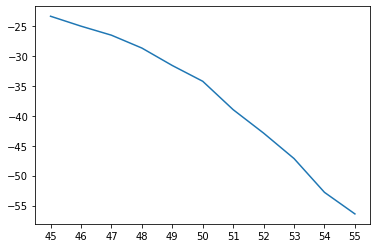

In [68]:
fig, ax = plt.subplots()
plt.plot([e[1] for e in perplexityvalues])
plt.xticks(range(len(perplexityvalues)), [e[0] for e in perplexityvalues])

I looped through 49 topics to 51 topics and printed the typical words for the topics.

In [69]:
ldacorpus_m3 = ldacorpus_m1
id2word_m3 = id2word_m1
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)
for n in np.arange(49,52):
    lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=n,random_state=40)
    print(f"When the number of topics is {n}")
    print(lda_m3.print_topics(num_words=5))
    print("\n")

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


When the number of topics is 49
[(32, '0.068*"shooting" + 0.060*"series" + 0.047*"case" + 0.041*"middle" + 0.037*"age"'), (0, '0.124*"children" + 0.104*"american" + 0.051*"trial" + 0.028*"infections" + 0.028*"former"'), (12, '0.058*"second" + 0.053*"tv" + 0.049*"right" + 0.047*"wednesday" + 0.046*"seats"'), (17, '0.051*"kids" + 0.030*"federal" + 0.030*"officials" + 0.026*"health" + 0.024*"care"'), (21, '0.311*"buy" + 0.051*"international" + 0.028*"healthcare" + 0.023*"familiar" + 0.021*"talks"'), (16, '0.048*"plan" + 0.047*"man" + 0.039*"strategy" + 0.035*"better" + 0.034*"mask"'), (40, '0.131*"unvaccinated" + 0.047*"employees" + 0.044*"mandate" + 0.044*"vaccinated" + 0.039*"results"'), (27, '0.046*"make" + 0.036*"recovery" + 0.028*"days" + 0.025*"supply" + 0.023*"amid"'), (23, '0.085*"5" + 0.037*"2022" + 0.035*"weeks" + 0.035*"come" + 0.024*"turn"'), (9, '0.061*"review" + 0.051*"potential" + 0.038*"sale" + 0.025*"closing" + 0.013*"saudi"'), (7, '0.078*"200" + 0.030*"vaccine" + 0.029*"

#### Filtering extremes
I looped through different percentages for the "no_above" hyperparameter and realized there was no significant differences in results when varying the percentages. Therefore, I decided to set the "no_above" to 0.7 because I think model with no words occur in more than 70.0 % of the documents makes sense to me.

In [70]:
percentage = [0.4,0.5,0.6,0.7,0.8,0.9]

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
for p in percentage:
    id2word_m4 = id2word_m1    
    id2word_m4.filter_extremes(no_below=5, no_above=p)
    ldacorpus_m4 = [id2word_m4.doc2bow(doc) for doc in ldainput_m1]
    tfidfcorpus_m4 = models.TfidfModel(ldacorpus_m4)
    lda_m4 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=49, random_state=40) 
    print ("\nModel with no words that occur more than in ",(p*100),"% of the documents results in the following words:\n\n")
    print (lda_m4.print_topics())

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Model with no words that occur more than in  40.0 % of the documents results in the following words:


[(46, '0.070*"demand" + 0.038*"earlier" + 0.036*"buying" + 0.032*"enough" + 0.030*"means" + 0.030*"raising" + 0.027*"stronger" + 0.026*"research" + 0.025*"instead" + 0.023*"prices"'), (32, '0.063*"others" + 0.056*"results" + 0.047*"middle" + 0.040*"wave" + 0.033*"levels" + 0.033*"africa" + 0.032*"increased" + 0.030*"virus" + 0.026*"approach" + 0.025*"election"'), (25, '0.053*"tv" + 0.035*"age" + 0.031*"lawsuit" + 0.030*"full" + 0.026*"expects" + 0.025*"impact" + 0.024*"repeat" + 0.020*"turn" + 0.019*"preparing" + 0.018*"youtube"'), (48, '0.071*"shooting" + 0.033*"similar" + 0.026*"police" + 0.022*"longer" + 0.022*"speaks" + 0.022*"america" + 0.019*"protected" + 0.019*"violence" + 0.018*"surge" + 0.018*"california"'), (38, '0.038*"2022" + 0.036*"uk" + 0.028*"variants" + 0.026*"disease" + 0.025*"packages" + 0.024*"normal" + 0.023*"thing" + 0.022*"looking" + 0.019*"control" + 0.019*"rep


Model with no words that occur more than in  70.0 % of the documents results in the following words:


[(46, '0.070*"demand" + 0.038*"earlier" + 0.036*"buying" + 0.032*"enough" + 0.030*"means" + 0.030*"raising" + 0.027*"stronger" + 0.026*"research" + 0.025*"instead" + 0.023*"prices"'), (32, '0.063*"others" + 0.056*"results" + 0.047*"middle" + 0.040*"wave" + 0.033*"levels" + 0.033*"africa" + 0.032*"increased" + 0.030*"virus" + 0.026*"approach" + 0.025*"election"'), (25, '0.053*"tv" + 0.035*"age" + 0.031*"lawsuit" + 0.030*"full" + 0.026*"expects" + 0.025*"impact" + 0.024*"repeat" + 0.020*"turn" + 0.019*"preparing" + 0.018*"youtube"'), (48, '0.071*"shooting" + 0.033*"similar" + 0.026*"police" + 0.022*"longer" + 0.022*"speaks" + 0.022*"america" + 0.019*"protected" + 0.019*"violence" + 0.018*"surge" + 0.018*"california"'), (38, '0.038*"2022" + 0.036*"uk" + 0.028*"variants" + 0.026*"disease" + 0.025*"packages" + 0.024*"normal" + 0.023*"thing" + 0.022*"looking" + 0.019*"control" + 0.019*"rep

#### N-grams
Including bigrams doesn't improve the model, therefore, use unigram only.

In [72]:
text_bigrams = [["_".join(tup) for tup in nltk.ngrams(n.split(),2)] for n in text]

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
assert len(text)==len(text_bigrams)
text_uniandbigrams = []
for a,b in zip([n.split() for n in text],text_bigrams):
    text_uniandbigrams.append(a + b)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
id2word_m5 = corpora.Dictionary(text_uniandbigrams)
id2word_m5.filter_extremes(no_below=5, no_above=0.7)
ldacorpus_m5 = [id2word_m5.doc2bow(doc) for doc in text_uniandbigrams]
tfidfcorpus_m5 = models.TfidfModel(ldacorpus_m5)
lda_m5 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m5[ldacorpus_m5],id2word=id2word_m5,num_topics=49, random_state=40)
lda_m5.print_topics()

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(39,
  '0.026*"soon" + 0.019*"quicktake" + 0.017*"issues" + 0.017*"2" + 0.016*"potential" + 0.015*"evidence" + 0.013*"extend" + 0.011*"management" + 0.011*"options" + 0.011*"russia"'),
 (4,
  '0.078*"vaccines" + 0.048*"covid19_vaccines" + 0.033*"strategy" + 0.033*"treatment" + 0.028*"lawsuit" + 0.022*"shortages" + 0.022*"covid19" + 0.018*"focus" + 0.016*"announce" + 0.015*"moment"'),
 (17,
  '0.025*"city" + 0.021*"“the" + 0.021*"16" + 0.021*"new_york" + 0.020*"york" + 0.019*"price" + 0.019*"meet" + 0.016*"initial" + 0.016*"california" + 0.015*"new"'),
 (37,
  '0.027*"star" + 0.022*"investments" + 0.021*"last_week" + 0.020*"sunday" + 0.020*"daily" + 0.020*"election_results" + 0.018*"likely" + 0.018*"claims" + 0.016*"election" + 0.015*"results"'),
 (47,
  '0.063*"delta" + 0.027*"members" + 0.024*"nail" + 0.023*"step" + 0.019*"official" + 0.016*"faces" + 0.016*"variant" + 0.016*"impact" + 0.015*"delta_variant" + 0.014*"november"'),
 (43,
  '0.058*"series" + 0.031*"right" + 0.026*"19" + 0

#### Tuning alpha and eta
I set both the alpha and eta to "auto", set iterations to 20 and passes to 5 to optimize the result.

In [75]:
id2word_m6 = id2word_m5
ldacorpus_m6 = ldacorpus_m5
tfidfcorpus_m6 = models.TfidfModel(ldacorpus_m6)
lda_m6 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m6[ldacorpus_m6],
                                  id2word=id2word_m6,
                                  num_topics=49, 
                                  alpha='auto', 
                                  eta = 'auto',
                                  passes=5,
                                  iterations=20,
                                  random_state=40)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
topics = lda_m6.print_topics()
print(topics)

[(15, '0.110*"monthly" + 0.094*"health_insurance" + 0.054*"nov" + 0.049*"100" + 0.045*"middle" + 0.035*"age" + 0.029*"starting_nov" + 0.027*"face" + 0.024*"half" + 0.023*"dozens"'), (6, '0.068*"music" + 0.044*"read" + 0.025*"20" + 0.024*"makers" + 0.019*"beyond" + 0.019*"gap" + 0.018*"built" + 0.011*"traders" + 0.010*"months_ago" + 0.010*"20_years"'), (34, '0.092*"tv" + 0.025*"annual" + 0.023*"worth" + 0.022*"helped" + 0.020*"36" + 0.019*"atlanta" + 0.017*"steve" + 0.014*"talk" + 0.014*"end_year" + 0.014*"whose"'), (1, '0.048*"canceled" + 0.026*"run" + 0.026*"conservative" + 0.025*"fifth" + 0.023*"town" + 0.022*"expensive" + 0.021*"arrested" + 0.020*"jobs" + 0.017*"two_years" + 0.014*"targeting"'), (12, '0.058*"weekly" + 0.052*"hire" + 0.050*"games" + 0.026*"violence" + 0.025*"fourth" + 0.025*"names" + 0.023*"cities" + 0.021*"paying" + 0.019*"mark" + 0.016*"credit"'), (24, '0.054*"wsjwhatsnow" + 0.044*"game" + 0.029*"means" + 0.025*"turning" + 0.019*"theres" + 0.018*"emissions" + 0.018

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
lda_m6.top_topics(tfidfcorpus_m6[ldacorpus_m6])

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[([(0.061544858, 'delta_air'),
   (0.05994645, 'air_lines'),
   (0.054301273, 'lines'),
   (0.05141787, 'delta'),
   (0.048599984, 'air'),
   (0.031557314, 'vaccine'),
   (0.029823607, 'buy'),
   (0.026800977, 'covid19'),
   (0.020428086, 'new'),
   (0.019931871, 'says'),
   (0.019286834, 'rt'),
   (0.016610598, 'us'),
   (0.015981155, 'said'),
   (0.014633855, 'employees'),
   (0.013528052, 'people'),
   (0.013145961, '200'),
   (0.01069174, 'week'),
   (0.010649019, 'first'),
   (0.010591709, 'one'),
   (0.010523261, 'year')],
  -3.0632341402477956),
 ([(0.03474702, 'coronavirus'),
   (0.032674197, 'pandemic'),
   (0.027029887, 'could'),
   (0.026324378, 'health'),
   (0.024412917, 'world'),
   (0.023508875, 'may'),
   (0.023095898, 'company'),
   (0.022069538, 'effective'),
   (0.020956807, 'day'),
   (0.017347103, 'demand'),
   (0.016148945, 'made'),
   (0.015765715, 'help'),
   (0.015550662, 'still'),
   (0.015089512, 'since'),
   (0.015053537, 'plans'),
   (0.014718858, 'even'),


In [78]:
vis_data = gensimvis.prepare(lda_m6,ldacorpus_m6,id2word_m6)
pyLDAvis.display(vis_data)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
cm_m6 = models.CoherenceModel(model=lda_m6, corpus=tfidfcorpus_m6[ldacorpus_m6], coherence='u_mass')
co_m6 = cm_m6.get_coherence()
print(co_m6)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-13.908211625125162


In [82]:
a= cm_m6.get_coherence_per_topic()
print(a)

[-17.355652023923653, -17.602033717653576, -14.876846496831048, -16.773037436890387, -16.24795081796783, -12.274350332649522, -15.6662360512322, -13.892313036645383, -12.312042256725434, -14.296400731696021, -13.986171987498198, -11.848371339939762, -16.98990366511105, -15.402381613750055, -15.55158545021476, -15.522169259470262, -14.751541511195171, -14.29910679808134, -15.833414723779189, -12.33878045102216, -6.491559756074229, -14.961863240325554, -14.3064714626039, -3.0632341402477956, -17.151251628096517, -15.152882690363667, -15.718077240702055, -9.67225994626952, -4.65790114732546, -16.62816067653658, -16.00180281281006, -6.5957208176475985, -13.90161833976681, -17.43727515319292, -17.886662399364926, -15.697264962859203, -13.946586291143445, -16.128447962835548, -17.325027471024757, -15.860030117862028, -16.56525028052509, -6.352171875414732, -11.895646788207873, -15.263185830721417, -17.40359317259659, -16.7034686834963, -15.211093356790688, -8.505316229694918, -7.198255454355

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
print ("Final Topics:")
topics

Final Topics:


c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(15,
  '0.110*"monthly" + 0.094*"health_insurance" + 0.054*"nov" + 0.049*"100" + 0.045*"middle" + 0.035*"age" + 0.029*"starting_nov" + 0.027*"face" + 0.024*"half" + 0.023*"dozens"'),
 (6,
  '0.068*"music" + 0.044*"read" + 0.025*"20" + 0.024*"makers" + 0.019*"beyond" + 0.019*"gap" + 0.018*"built" + 0.011*"traders" + 0.010*"months_ago" + 0.010*"20_years"'),
 (34,
  '0.092*"tv" + 0.025*"annual" + 0.023*"worth" + 0.022*"helped" + 0.020*"36" + 0.019*"atlanta" + 0.017*"steve" + 0.014*"talk" + 0.014*"end_year" + 0.014*"whose"'),
 (1,
  '0.048*"canceled" + 0.026*"run" + 0.026*"conservative" + 0.025*"fifth" + 0.023*"town" + 0.022*"expensive" + 0.021*"arrested" + 0.020*"jobs" + 0.017*"two_years" + 0.014*"targeting"'),
 (12,
  '0.058*"weekly" + 0.052*"hire" + 0.050*"games" + 0.026*"violence" + 0.025*"fourth" + 0.025*"names" + 0.023*"cities" + 0.021*"paying" + 0.019*"mark" + 0.016*"credit"'),
 (24,
  '0.054*"wsjwhatsnow" + 0.044*"game" + 0.029*"means" + 0.025*"turning" + 0.019*"theres" + 0.018*"e

In [84]:
scoresperdoc=lda_m6.inference(ldacorpus_m6)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
len(scoresperdoc[0])

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


38138

In [104]:
df = pd.DataFrame.from_records(scoresperdoc[0])
df
#topic 23 has a very high score

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1.074888,0.049223,0.082056,0.088322,0.065054,0.161616,0.047256,0.117966,0.125358,0.069225,...,0.082772,0.068392,0.241281,0.147856,0.085075,0.063868,0.082151,0.090792,0.183671,0.208462
1,1.074888,0.049223,0.082056,0.088322,0.065054,0.161616,0.047256,0.117966,0.125358,0.069225,...,0.082772,0.068392,0.241281,0.147856,0.085075,0.063868,0.082151,0.090792,0.183671,0.208462
2,1.074888,0.049223,0.082056,0.088322,0.065054,0.161616,0.047256,0.117966,0.125358,0.069225,...,0.082772,0.068392,0.241281,0.147856,0.085075,0.063868,0.082151,0.090792,0.183671,0.208462
3,1.074888,0.049223,0.082056,0.088322,0.065054,0.161616,0.047256,0.117966,0.125358,0.069225,...,0.082772,0.068392,0.241281,0.147856,0.085075,0.063868,0.082151,0.090792,0.183671,0.208462
4,0.075367,0.049223,0.082056,0.088322,0.065054,0.161618,0.047256,0.117966,0.125358,0.069225,...,0.082772,0.068392,0.263356,0.147856,0.085075,0.063868,0.082151,0.090790,0.183749,0.208462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38133,0.075367,0.049223,0.082056,0.088322,0.065054,0.161616,0.047256,0.117966,0.125358,0.069225,...,0.082772,0.068392,0.241273,0.147856,0.085075,0.063868,0.082151,1.090677,0.183683,0.208462
38134,0.075367,0.049223,0.082056,0.088322,0.065054,0.161616,0.047256,0.117966,0.125358,0.069225,...,0.082772,1.068229,0.241273,0.147856,0.085075,0.063868,0.082151,0.090790,1.186005,0.208462
38135,0.075367,0.049223,0.082056,0.088322,0.065054,0.161759,0.047256,0.117966,0.125453,0.069225,...,0.082772,0.068392,1.240971,0.147882,0.085075,1.063828,0.082151,0.090790,0.183676,0.208462
38136,0.075367,0.049223,0.082056,0.088322,0.065054,0.161616,0.047256,0.117967,1.125338,0.069225,...,1.082484,0.068392,1.270977,1.166870,1.109207,0.063868,0.082151,1.090647,1.225059,0.208462


In [99]:
df = df.applymap(lambda x: int(x>1))
df

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
38134,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
38135,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
38136,0,0,0,0,0,0,0,0,1,0,...,1,0,1,1,1,0,0,1,1,0


In [100]:
media_topic = media.merge(df, left_index=True, right_index=True)

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
media_topic.head()

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,created_at,text,id,author_id,lang,username,text_clean,source_media,0,1,...,39,40,41,42,43,44,45,46,47,48
0,2021-12-31 12:06:05,'That was not the basis of the CDC's decision'...,1476887381336801280,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-12-30 02:46:02,'That was not the basis of the CDC's decision'...,1476384051154112512,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-12-29 13:31:07,'That was not the basis of the CDC's decision'...,1476184003526938624,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-12-29 06:31:02,'That was not the basis of the CDC's decision'...,1476078288661581824,2836421,en,MSNBC,that was not the basis of the cdcs decision dr...,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-08-25 19:34:01,Delta Air Lines CEO tells employees that they ...,1430614459077349376,2836421,en,MSNBC,delta air lines ceo tells employees that they ...,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
media_topic.to_csv("media_topic_lda.csv", sep = ",")

c:\users\tuski\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic modeling  -  media

In [ ]:
media = pd.read_csv("media_clean.csv", header = 0, delimiter = ",")
media.drop(labels = ["Unnamed: 0"], axis = 1, inplace = True)
media_text = media["text_clean"].to_list() # get the preprocessed text for topic modeling

In [ ]:
media_text[:10]

In [ ]:
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=5, max_df=.5) # custome the CountVectorizer

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=3) 

In [ ]:
topic_model = BERTopic(vectorizer_model=vectorizer_model, calculate_probabilities=False, low_memory=True, verbose=True, 
                       nr_topics="auto", diversity = 0.2, min_topic_size = 30, hdbscan_model=hdbscan_model) # create the topic model

In [ ]:
topics, probs = topic_model.fit_transform(media_text)

In [ ]:
# min_samples=3
topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(-1)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.get_topic(1)

In [ ]:
topic_model.get_representative_docs(1)

In [ ]:
representative_docs = topic_model.get_representative_docs() #get representative docs for all topics, will return a dict

In [ ]:
df = pd.DataFrame.from_dict(representative_docs, orient ='index') 
df.head()

In [ ]:
df.to_excel('media_representative_docs.xlsx')

### Dynamic topic modeling

In [ ]:
media.head()

In [ ]:
timestamps = media.created_at.to_list()

In [ ]:
topics_over_time = topic_model.topics_over_time(media_text, topics, timestamps, nr_bins=20)

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

Save the topic and probability per doc to the original dataframe

In [ ]:
media_topic = pd.DataFrame()

In [ ]:
media_topic['topic']  = topics
media_topic['probs']  = probs

In [ ]:
media = media.join(media_topic)

In [ ]:
media.head()

In [ ]:
media.to_csv("media_topic.csv", sep = ",")

In [ ]:
topic_model.save("media_model") # save the model

### Other

In [ ]:
# manual = pd.read_excel('media_representative_docs.xlsx', index_col=0)

# media_model = BERTopic.load("media_model")

1. ```media_text = [str(text) for text in media_text if len(str(text)) > 0]```

will report "sequence item 0: expected str instance, float found" if not do this
but when using vectorizer should be fine
https://githubhot.com/repo/MaartenGr/BERTopic/issues/259

2. get topics and probabilities for each doc from a loaded model

from: https://github.com/MaartenGr/BERTopic/issues/283

3. If the model is a fresh one, no need to run the following codes, the topics and probs are already calculated:

```topics = topic_model._map_predictions(topic_model.hdbscan_model.labels_)
probs = topic_model.hdbscan_model.probabilities_```